In [1]:
import scipy.io
import torch
from torch.utils import data
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
from classify_svhn import *
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os


## Dataloader

In [2]:
def make_dataloaders(train_file,test_file,split_size=0.20,batch_size=16,transform=None):
    
    traindata = scipy.io.loadmat(train_file)
    testdata = scipy.io.loadmat(test_file)
    
    X = traindata['X']  
    X = X.T
    
    X_test = testdata['X']
    X_test = X_test.T
    
    X_train, X_valid =  train_test_split( X, test_size=split_size, random_state=42)
    
    train_dataset = SVHN_dataset(X_train,transform)
    valid_dataset = SVHN_dataset(X_valid,transform)
    test_dataset = SVHN_dataset(X_test,transform)
    
    train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=4)

    valid_loader = DataLoader(valid_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=4)
    
    test_loader = DataLoader(test_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=4)
    
    return train_loader, valid_loader, test_loader

In [3]:
class SVHN_dataset(data.Dataset):
 
    def __init__(self, images, transform=None):
        'Initialization'
        self.images = images
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        image = self.images[index,:,:,:]
        
        sample = image.T

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
to_tensor = transforms.ToTensor()
normalize= transforms.Normalize((.5, .5, .5),(.5, .5, .5))

# Declare transformations
transform = transforms.Compose([to_tensor,
                               normalize])
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used: ", device)

Device used:  cuda:0


In [5]:
train_loader,valid_loader,test_loader = make_dataloaders("train_32x32.mat","test_32x32.mat",split_size=0.20,batch_size=32,transform=transform)

## Model

In [6]:

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 4, 4)



class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=256, z_dim=100):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            
            # input size is 3x32x32
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1,bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 32x32x32
            nn.Conv2d(32, 64, 4, 2, 1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 64x16x16
            nn.Conv2d(64, 256, 4, 2, 1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 512 x 4 x 4
            nn.Conv2d(512, 256, 4, 1, 0,bias=False),
            # state size = 256 x 1 x 1
            
        )
        
        self.flat = Flatten()
        self.unflat = UnFlatten()
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            
            # input is Z, going into a convolution
            nn.ConvTranspose2d(256, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 16 x 16
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. 32 x 32 x 32
            nn.ConvTranspose2d(32, 3, 3, 1, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 32 x 32
        )
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        h = self.flat(h)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
 
        z = self.fc3(z)
        z = z.view([z.size(0), 256, 1, 1])
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

## utility functions

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
def show(img,epoch,path):
    title = "VAE_epoch{}.png".format(epoch)
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest', aspect='auto')
    plt.tight_layout()
    plt.savefig(os.path.join(path, title),dpi=300)

In [9]:
def loss_fn(recon_x, x, mu, logvar):
    MSE_loss = nn.MSELoss(reduction="sum")
    MSE = MSE_loss(recon_x, x
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

## Training

100%|██████████| 1832/1832 [02:55<00:00, 10.44it/s]


4593.236409816159


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


3460.135431014815


100%|██████████| 1832/1832 [02:56<00:00, 10.41it/s]


3217.2317992631006


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


3080.3667663840747


100%|██████████| 1832/1832 [02:55<00:00, 10.42it/s]


2966.823278968511


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


2879.341330848927


100%|██████████| 1832/1832 [02:55<00:00, 10.41it/s]


2819.425390518388


100%|██████████| 1832/1832 [02:56<00:00, 11.28it/s]


2764.502100049148


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


2721.2576525825602


100%|██████████| 1832/1832 [02:56<00:00, 11.29it/s]


2685.00973710639


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


2654.436782037327


100%|██████████| 1832/1832 [02:56<00:00, 10.39it/s]


2636.486973591767


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


2615.3806646088847


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


2602.9825421462415


100%|██████████| 1832/1832 [02:56<00:00, 11.31it/s]


2577.8189282146604


100%|██████████| 1832/1832 [02:56<00:00, 10.39it/s]


2555.650428871921


100%|██████████| 1832/1832 [02:56<00:00, 11.34it/s]


2540.259263350974


100%|██████████| 1832/1832 [02:56<00:00, 10.39it/s]


2529.586744883175


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


2516.4406061963746


100%|██████████| 1832/1832 [02:56<00:00, 10.39it/s]


2506.924629044845


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]
/miniconda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2491.827077207607


100%|██████████| 1832/1832 [02:56<00:00, 10.39it/s]


2479.266296653248


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


2466.0302585118725


100%|██████████| 1832/1832 [02:56<00:00, 10.39it/s]


2459.5800315490455


100%|██████████| 1832/1832 [02:56<00:00, 11.26it/s]


2453.9679394184764


100%|██████████| 1832/1832 [02:56<00:00, 11.32it/s]


2442.1940309616157


100%|██████████| 1832/1832 [02:55<00:00, 11.29it/s]


2436.1734929646987


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


2429.653271337784


100%|██████████| 1832/1832 [02:56<00:00, 10.41it/s]


2421.2139245578815


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


2413.8973603227773


100%|██████████| 1832/1832 [02:56<00:00, 10.41it/s]


2403.6576387497016


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


2397.6238334022755


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


2389.6846554685367


100%|██████████| 1832/1832 [02:56<00:00, 10.40it/s]


2384.296624595942


100%|██████████| 1832/1832 [02:56<00:00, 11.31it/s]


2379.926150126228


100%|██████████| 1832/1832 [02:56<00:00, 11.28it/s]


2376.0797486950737


100%|██████████| 1832/1832 [02:55<00:00, 11.30it/s]


2368.8857907624224


100%|██████████| 1832/1832 [02:56<00:00, 10.39it/s]


2361.732873775032


100%|██████████| 1832/1832 [02:58<00:00, 10.28it/s]


2358.496497874697


100%|██████████| 1832/1832 [02:59<00:00, 10.22it/s]


2353.674453135661


100%|██████████| 1832/1832 [02:58<00:00, 10.24it/s]


2350.0604845071985


100%|██████████| 1832/1832 [02:59<00:00, 10.23it/s]


2343.7244455928885


100%|██████████| 1832/1832 [02:59<00:00, 11.08it/s]


2338.1383105948503


100%|██████████| 1832/1832 [02:59<00:00, 10.21it/s]


2334.382379456899


100%|██████████| 1832/1832 [02:59<00:00, 10.22it/s]


2330.933968823029


100%|██████████| 1832/1832 [02:59<00:00, 11.12it/s]


2326.3116644980087


100%|██████████| 1832/1832 [02:59<00:00, 10.21it/s]


2320.9470216176396


100%|██████████| 1832/1832 [02:59<00:00, 10.21it/s]


2315.2344509607838


100%|██████████| 1832/1832 [02:59<00:00, 11.07it/s]


2312.3842424950744


100%|██████████| 1832/1832 [02:59<00:00, 11.02it/s]


2308.375112208737


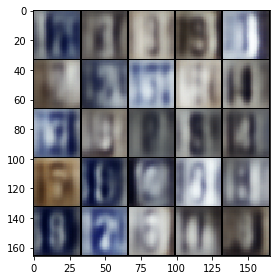

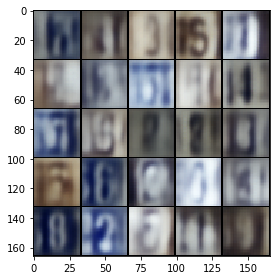

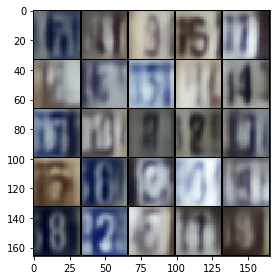

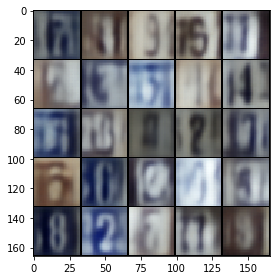

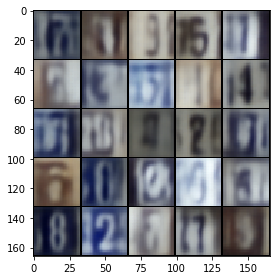

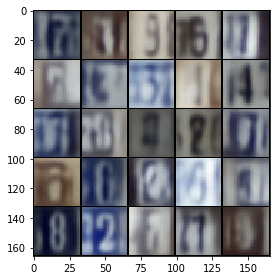

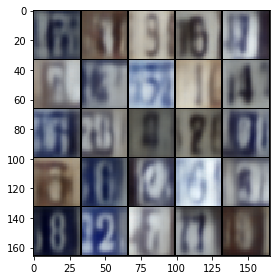

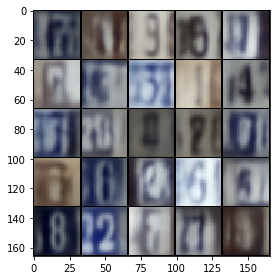

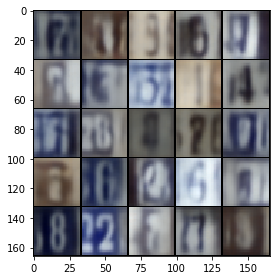

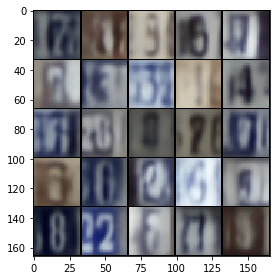

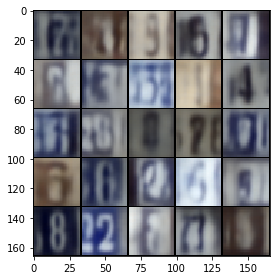

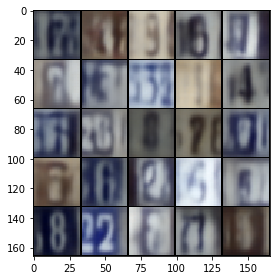

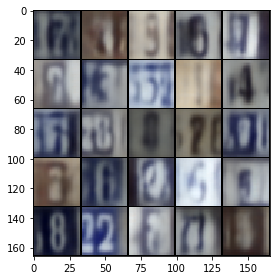

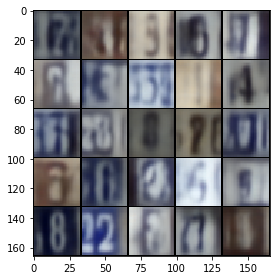

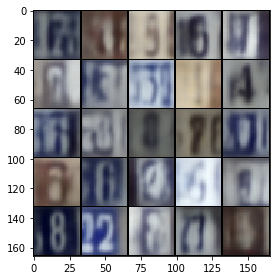

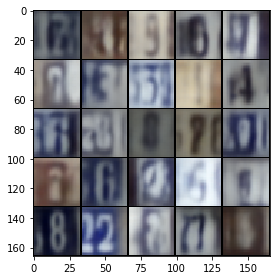

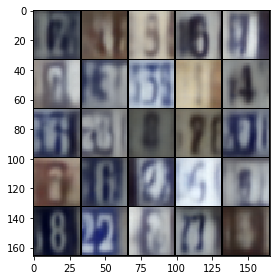

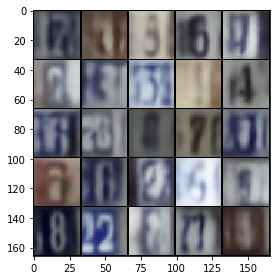

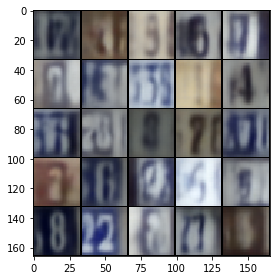

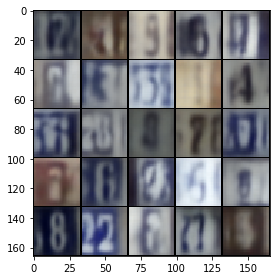

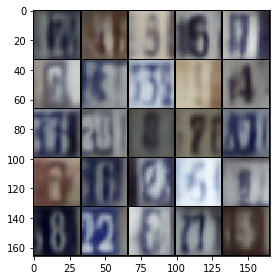

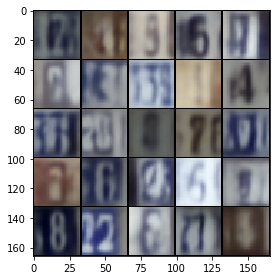

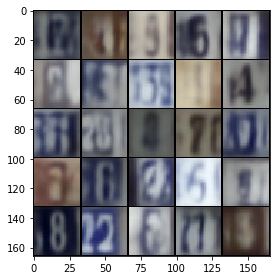

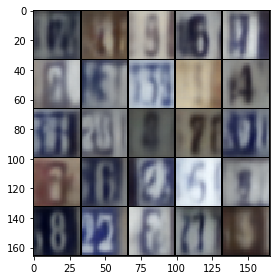

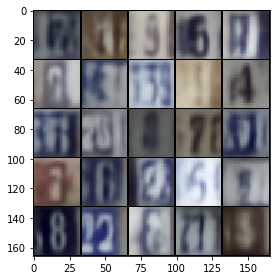

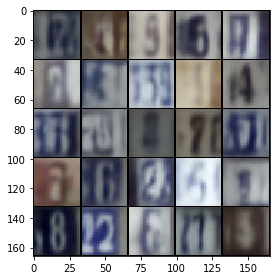

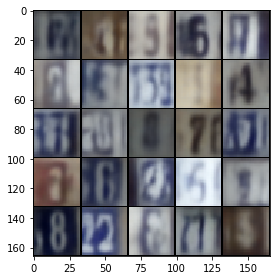

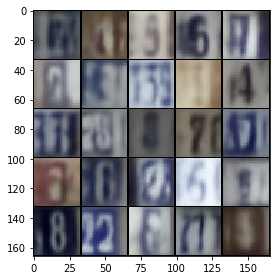

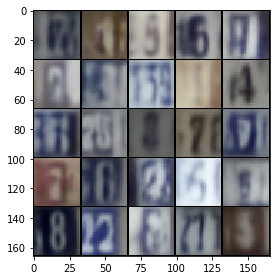

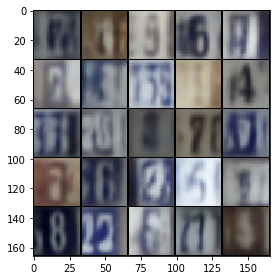

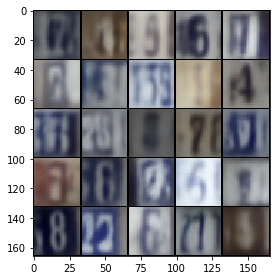

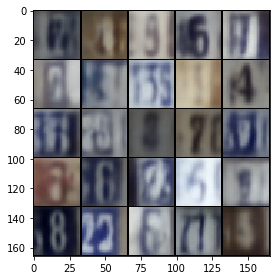

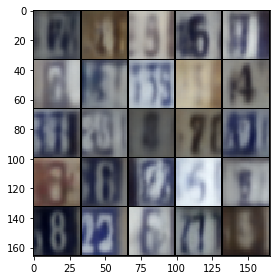

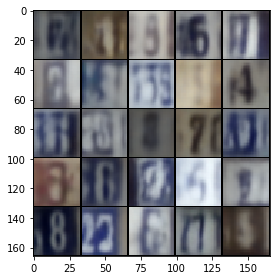

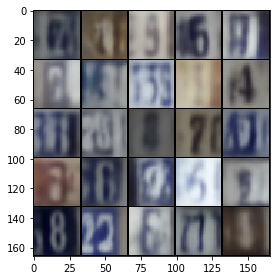

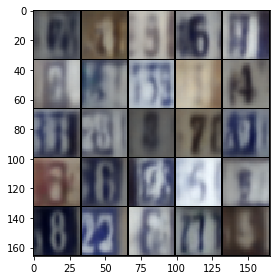

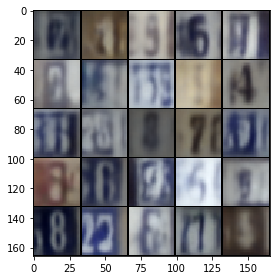

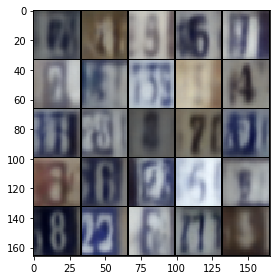

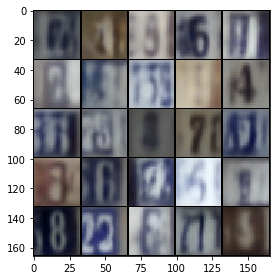

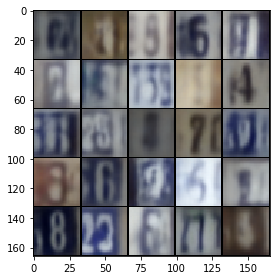

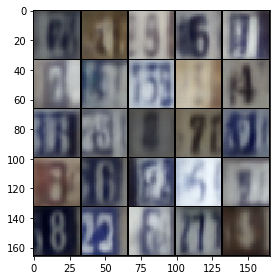

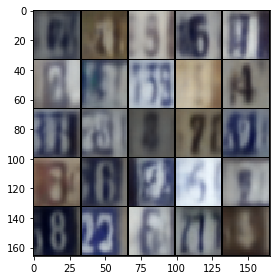

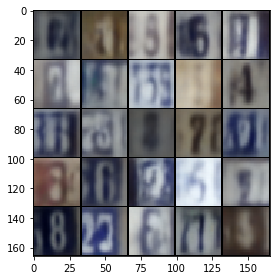

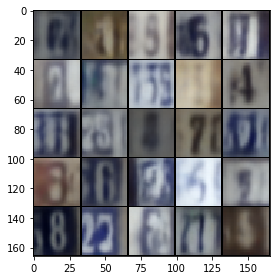

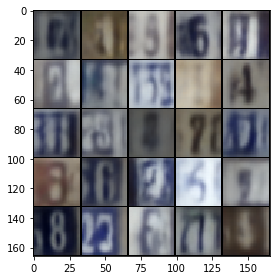

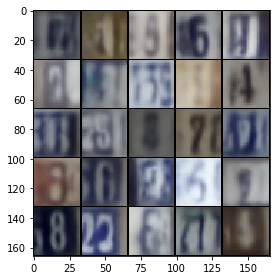

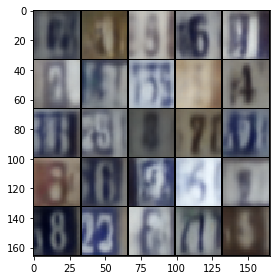

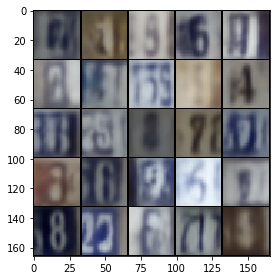

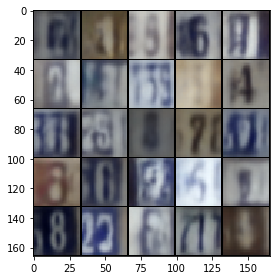

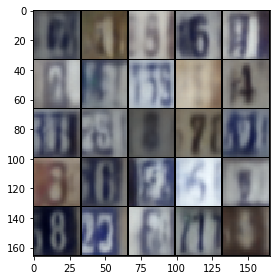

In [10]:
model = VAE().to(device)
model.apply(weights_init)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 50
bs=32

img_path = "VAE_img/"
noise = torch.randn(25, 100, device=device)
epoch_loss =[]

for epoch in range(epochs):
    loss_list = []
    for idx, batch in enumerate(tqdm(train_loader)):
        images = batch.to(device)
        recon_images, mu, logvar = model(images)
        loss = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(float(loss.detach().cpu()))

    torch.save(model.state_dict(), 'vae.torch')
    epoch_loss.append(np.mean(np.array(loss_list)))
    print(epoch_loss[-1])
    
    fake = model.decode(noise)
    fake = fake.detach().cpu()
    show(make_grid(fake, padding=1,normalize=True,nrow=5),epoch,img_path)
        

torch.save(model.state_dict(), 'vae.torch')